<a href="https://colab.research.google.com/github/dewamardana/Streamlit-Klasifikasi-Genre-Lagu/blob/main/FIX_Music_Genre_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PPDM A3 KLASIFIKASI GENRE MUSIK

### Setup Notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
Root = "/content/drive/MyDrive/Colab Notebooks/PPDM/"
os.chdir(Root)

##Import Dependencies

In [ ]:
# import TensorFlow
import tensorflow as tf

#Check the version of TensorFlow you are using
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.15.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import os
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import seaborn as sns

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

import keras_tuner
from kerastuner.tuners import RandomSearch

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

import time
from datetime import datetime

import pickle
import joblib

## Exploratory Data Analysis

In [ ]:
audio_path = "/content/drive/MyDrive/Colab Notebooks/PPDM/Data-Audio/genres_original"
metadata = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/PPDM/Data-Audio/features_30_sec.csv")
metadata.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


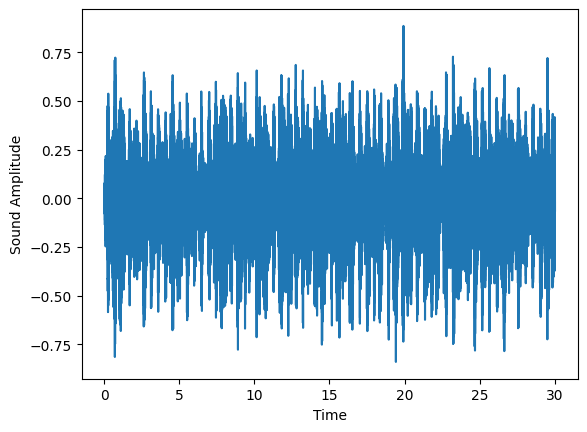

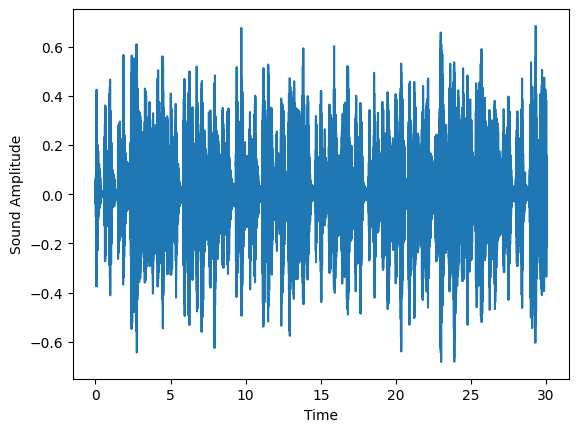

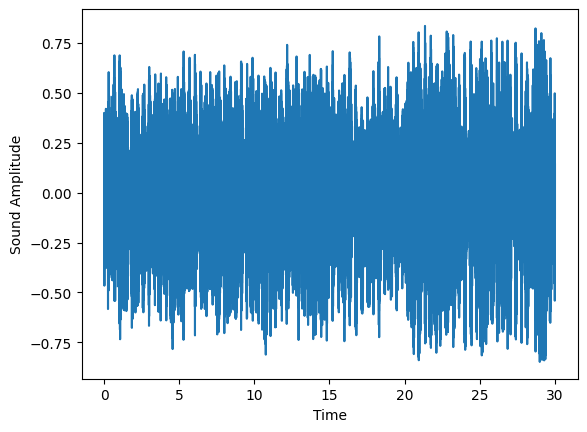

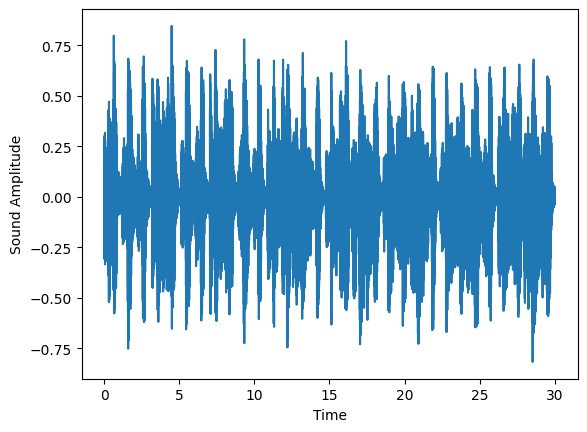

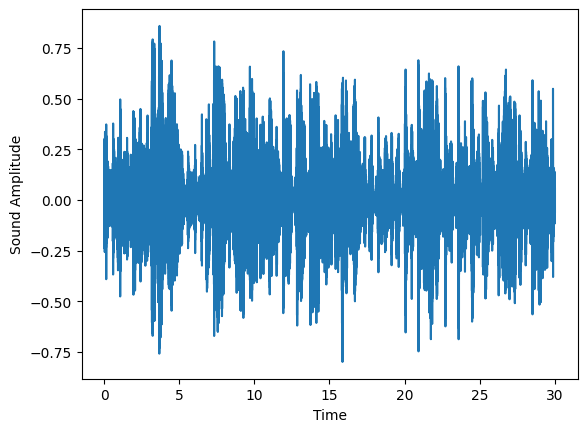

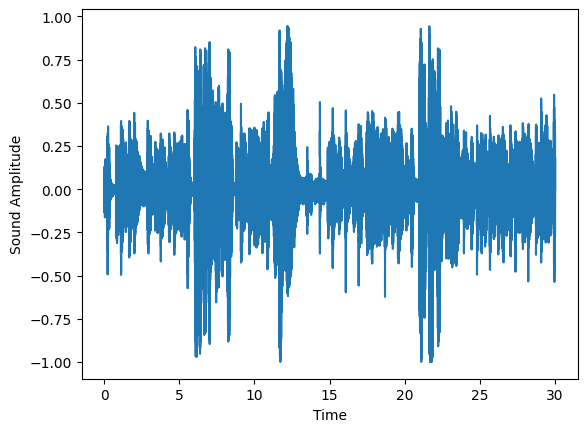

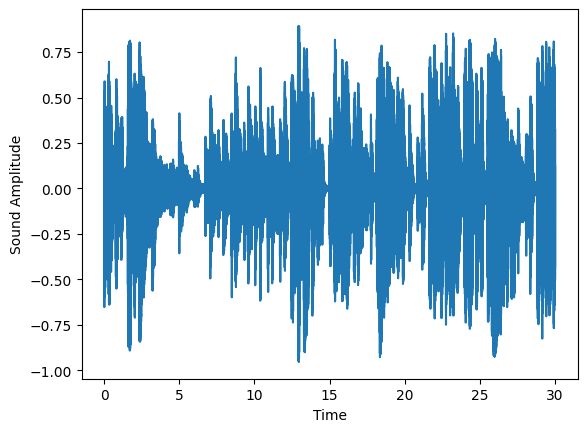

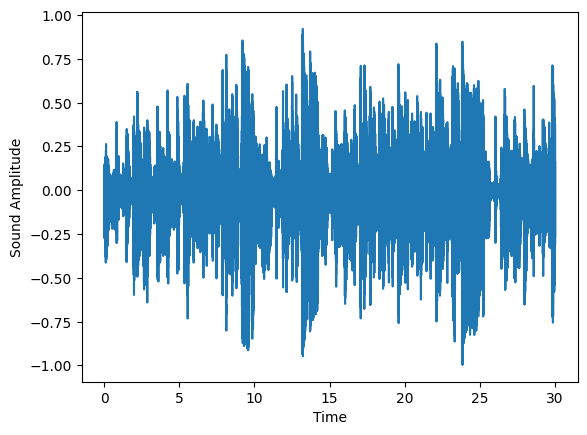

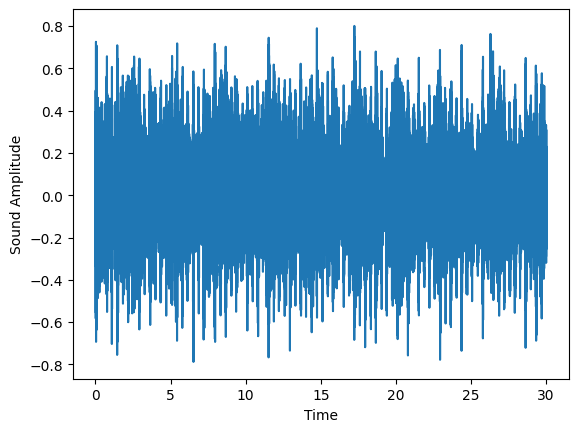

In [ ]:
filepath = "/content/drive/MyDrive/Colab Notebooks/PPDM/Data-Audio/genres_original/blues/blues.0000"

for i in range(9):
    audio, sfreq = librosa.load(filepath+str(i)+".wav")
    time = np.arange(0, len(audio))/sfreq
    plt.plot(time,audio)
    plt.xlabel("Time")
    plt.ylabel("Sound Amplitude")
    plt.show()

##AUGMENTASI DATA

In [ ]:
def split_audio(file, segment_length=3):
    try:
        audio, sample_rate = librosa.load(file, res_type='kaiser_fast')
        trimmed_audio, _ = librosa.effects.trim(audio)
    except Exception as e:
        print(f"Error loading {file}: {e}")
        return [], 0

    segment_frames = segment_length * sample_rate
    segments = [trimmed_audio[i:i + segment_frames] for i in range(0, len(trimmed_audio), segment_frames)]
    return segments, sample_rate

## EKSTRAKSI FITUR

### Mel Frequency Cepstral Coefficients (MFCC)
Ada serangkaian langkah untuk menghasilkan fitur-fitur ini:

Karena sinyal audio terus berubah, pertama kita membagi sinyal ini menjadi frame-frame yang lebih kecil. Setiap frame memiliki panjang sekitar 20-40 ms. Kemudian kita mencoba mengidentifikasi berbagai frekuensi yang ada di setiap frame. Sekarang, pisahkan frekuensi linguistik dari kebisingan. Untuk menghilangkan kebisingan, kita kemudian mengambil transformasi kosinus diskret (DCT) dari frekuensi-frekuensi ini. Menggunakan DCT, kita hanya mempertahankan urutan frekuensi tertentu yang memiliki probabilitas tinggi.

In [ ]:
def ekstraksi_mfcc(audio_segment, sample_rate):
    mfcc_features = librosa.feature.mfcc(y=audio_segment, sr=sample_rate, n_mfcc=40)
    mfcc_scaled_features = np.mean(mfcc_features.T, axis=0)
    return mfcc_scaled_features, mfcc_features.shape[1]

In [ ]:
### Mengiterasikan semua audio dan mengekstrak fiturnya
### Menggunakan Mel-Frequency Cepstral Coefficients

extracted_features = []
for index_num, row in tqdm(metadata.iterrows()):
    try:
        final_class_labels = row["label"]
        file_name = os.path.join(os.path.abspath(audio_path), final_class_labels, str(row["filename"]))
        segments, sample_rate = split_audio(file_name, segment_length=3)
        for segment in segments:
            if len(segment) == 3 * sample_rate:  # Pastikan segment_length = 3
                data = ekstraksi_mfcc(segment, sample_rate)
                if data is not None:
                    extracted_features.append([data, final_class_labels])
    except Exception as e:
        print(f"Error processing {file_name}: {e}")
        continue

554it [02:35,  2.99it/s]<ipython-input-59-5d0587dbf4d1>:3: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(file, res_type='kaiser_fast')
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
555it [02:36,  1.90it/s]

Error loading /content/drive/MyDrive/Colab Notebooks/PPDM/Data-Audio/genres_original/jazz/jazz.00054.wav: 


1000it [04:36,  3.62it/s]


In [ ]:
file = "/content/drive/MyDrive/Colab Notebooks/PPDM/Data-Audio/genres_original/blues/blues.00000.wav"
segment_length = 3

segments, sample_rate = split_audio(file, segment_length)
print(f"Sample rate: {sample_rate}")

if segments:
    audio_segment = segments[0]
    mfcc_scaled_features, num_frames = ekstraksi_mfcc(audio_segment, sample_rate)
    print(f"Number of frames: {num_frames}")
else:
    print("No segments generated")


Sample rate: 22050
Number of frames: 130


In [ ]:
metadata.drop (index=554, axis=0, inplace=True)

##Data Preparation

In [ ]:
extracted_features_df = pd.DataFrame(extracted_features, columns=['feature', 'class'])
extracted_features_df.head()

extracted_features_df.to_csv('/content/drive/MyDrive/Colab Notebooks/PPDM/MFCC-Musik.csv',index=False)

In [ ]:
extracted_features_df['class'].value_counts()

class
blues        1000
metal        1000
pop          1000
reggae       1000
disco         999
rock          999
classical     998
country       997
hiphop        997
jazz          990
Name: count, dtype: int64

In [ ]:
X = np.array(extracted_features_df['feature'].tolist())
y = np.array(extracted_features_df['class'].tolist())

In [ ]:
X.shape

(9980, 40)

In [ ]:
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))

In [ ]:
y.shape

(9980, 10)

Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
X_train

array([[-1.71924782e+01,  6.32232285e+01,  9.18619633e+00, ...,
        -2.09675860e+00, -1.63653541e+00, -2.40688562e+00],
       [-6.45398712e+01,  1.34645798e+02, -4.23981628e+01, ...,
        -3.55556870e+00, -3.05666447e+00, -7.65884066e+00],
       [-1.04997055e+02,  6.57698364e+01,  3.40871582e+01, ...,
         1.20531487e+00,  1.00995088e+00, -2.32592896e-01],
       ...,
       [-2.31795120e+02,  4.36787605e+01,  3.37313118e+01, ...,
         1.36001754e+00,  2.29113960e+00,  1.98836267e+00],
       [-2.80817719e+02,  7.75990906e+01, -2.21888447e+01, ...,
        -6.85480356e-01,  2.16558933e+00, -1.65938646e-01],
       [-1.80767761e+02,  1.29066376e+02, -7.74616909e+00, ...,
        -5.92599297e+00, -8.84752795e-02, -2.08371520e+00]], dtype=float32)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7984, 40)
(1996, 40)
(7984, 10)
(1996, 10)


## MODEL


### Merancang Model

In [ ]:
num_labels = y.shape[1]

In [ ]:
model = Sequential()
model.add(Dense(1024,input_shape=(40,), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))

## FINAL LAYER
model.add(Dense(num_labels, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 1024)              41984     
                                                                 
 dropout_18 (Dropout)        (None, 1024)              0         
                                                                 
 dense_22 (Dense)            (None, 512)               524800    
                                                                 
 dropout_19 (Dropout)        (None, 512)               0         
                                                                 
 dense_23 (Dense)            (None, 256)               131328    
                                                                 
 dropout_20 (Dropout)        (None, 256)               0         
                                                                 
 dense_24 (Dense)            (None, 128)              

In [ ]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

### Model Fitting dan Time

In [ ]:
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)

In [ ]:
num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath=f'saved_models/audio_classification_{current_time}.hdf5', verbose=1, save_best_only=True)
start = datetime.now()

history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
247/250 [============================>.] - ETA: 0s - loss: 2.5438 - accuracy: 0.1274
Epoch 1: val_loss improved from inf to 2.16122, saving model to saved_models/audio_classification_10:46:03.hdf5
250/250 [==============================] - 6s 18ms/step - loss: 2.5413 - accuracy: 0.1273 - val_loss: 2.1612 - val_accuracy: 0.2951
Epoch 2/100
  5/250 [..............................] - ETA: 3s - loss: 2.1307 - accuracy: 0.2062

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


249/250 [============================>.] - ETA: 0s - loss: 2.1127 - accuracy: 0.2196
Epoch 2: val_loss improved from 2.16122 to 1.86950, saving model to saved_models/audio_classification_10:46:03.hdf5
250/250 [==============================] - 5s 21ms/step - loss: 2.1130 - accuracy: 0.2196 - val_loss: 1.8695 - val_accuracy: 0.3397
Epoch 3/100
250/250 [==============================] - ETA: 0s - loss: 1.8839 - accuracy: 0.3243
Epoch 3: val_loss improved from 1.86950 to 1.70097, saving model to saved_models/audio_classification_10:46:03.hdf5
250/250 [==============================] - 6s 23ms/step - loss: 1.8839 - accuracy: 0.3243 - val_loss: 1.7010 - val_accuracy: 0.3978
Epoch 4/100
250/250 [==============================] - ETA: 0s - loss: 1.7641 - accuracy: 0.3572
Epoch 4: val_loss improved from 1.70097 to 1.60254, saving model to saved_models/audio_classification_10:46:03.hdf5
250/250 [==============================] - 4s 18ms/step - loss: 1.7641 - accuracy: 0.3572 - val_loss: 1.6025 

In [ ]:
model.evaluate(X_test, y_test, verbose=0)

[0.51973557472229, 0.891783595085144]

In [ ]:
best_model = load_model('saved_models/audio_classification_10:46:03.hdf5')
best_model.save('best_model.h5')

# Evaluasi model pada data uji
loss, accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Prediksi kelas pada data uji
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(y_true, y_pred_classes))

accuracy_percent = accuracy * 100
print(f'Accuracy (%): {accuracy_percent}%')

Loss: 0.51973557472229, Accuracy: 0.891783595085144
63/63 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       180
           1       0.93      0.95      0.94       196
           2       0.80      0.93      0.86       206
           3       0.84      0.83      0.84       191
           4       0.91      0.82      0.86       207
           5       0.90      0.88      0.89       181
           6       0.95      0.96      0.95       212
           7       0.96      0.91      0.94       195
           8       0.91      0.91      0.91       214
           9       0.81      0.82      0.81       214

    accuracy                           0.89      1996
   macro avg       0.90      0.89      0.89      1996
weighted avg       0.89      0.89      0.89      1996

Accuracy (%): 89.1783595085144%


## MODEL DENGAN TUNING HYPERPARAMETER & K FOLD CROSS VALIDATION

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_input', min_value=512, max_value=1024, step=128),
                    input_shape=(40,), activation='relu'))
    model.add(Dropout(rate=hp.Choice('dropout_input', values=[0.2, 0.3, 0.4])))

    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=128, max_value=512, step=64),
                        activation='relu'))
        model.add(Dropout(rate=hp.Choice(f'dropout_{i}', values=[0.2, 0.3, 0.4])))

    model.add(Dense(10, activation='softmax'))  # Output layer dengan 10 kelas (sesuai dengan jumlah kelas)

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
# Inisialisasi tuner untuk pencarian hyperparameter
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Jumlah percobaan maksimum untuk pencarian acak
    executions_per_trial=1,  # Jumlah iterasi validasi untuk setiap percobaan
    directory='/content/drive/MyDrive/Colab Notebooks/PPDM',  # Direktori untuk menyimpan log dan hasil tuning
    project_name='audio_tuning_hyperparameter')  # Nama proyek untuk penyimpanan

# Lakukan pencarian tuner
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Ambil model terbaik
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluasi model terbaik pada data tes
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Simpan model terbaik menggunakan format h5
best_model.save('best_model_with_hyperparameter.h5')

# Simpan label encoder menggunakan pickle
with open('labelencoder.pkl', 'wb') as file:
    pickle.dump(labelencoder, file)

Trial 5 Complete [00h 00m 46s]
val_accuracy: 0.7204408645629883

Best val_accuracy So Far: 0.7710421085357666
Total elapsed time: 00h 02m 54s
63/63 [==============================] - 0s 3ms/step - loss: 0.6981 - accuracy: 0.7710
Loss: 0.6980785131454468, Accuracy: 0.7710421085357666


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
cv_scores = []

for train_idx, val_idx in kfold.split(X, np.argmax(y, axis=1)):
    model = Sequential([
        Dense(1024, input_shape=(40,), activation='relu'),
        Dropout(0.3),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(10, activation='softmax')  # Output layer dengan 10 kelas
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(X[train_idx], y[train_idx], epochs=10, batch_size=32, verbose=1)
    _, accuracy = model.evaluate(X[val_idx], y[val_idx], verbose=0)
    cv_scores.append(accuracy)

print(f'Cross-validation Scores: {cv_scores}')
print(f'Mean Accuracy: {np.mean(cv_scores)}, Std: {np.std(cv_scores)}')


Epoch 1/10
250/250 [==============================] - 6s 17ms/step - loss: 2.5201 - accuracy: 0.1495
Epoch 2/10
250/250 [==============================] - 6s 23ms/step - loss: 2.0411 - accuracy: 0.2624
Epoch 3/10
250/250 [==============================] - 5s 19ms/step - loss: 1.8381 - accuracy: 0.3394
Epoch 4/10
250/250 [==============================] - 4s 17ms/step - loss: 1.7379 - accuracy: 0.3650
Epoch 5/10
250/250 [==============================] - 5s 21ms/step - loss: 1.6678 - accuracy: 0.3942
Epoch 6/10
250/250 [==============================] - 5s 20ms/step - loss: 1.5850 - accuracy: 0.4315
Epoch 7/10
250/250 [==============================] - 4s 16ms/step - loss: 1.5030 - accuracy: 0.4569
Epoch 8/10
250/250 [==============================] - 4s 16ms/step - loss: 1.4329 - accuracy: 0.4872
Epoch 9/10
250/250 [==============================] - 6s 24ms/step - loss: 1.3808 - accuracy: 0.5060
Epoch 10/10
250/250 [==============================] - 4s 17ms/step - loss: 1.3486 - accura

In [ ]:
# Evaluasi model terbaik pada data uji
best_model = load_model('best_model_with_hyperparameter.h5')
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Prediksi kelas pada data uji
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(y_true, y_pred_classes))

# Simpan model terbaik menggunakan format .sav
joblib.dump(best_model, 'best_model_with_hyperparameter.sav')

accuracy_percent = accuracy * 100
print(f'Accuracy (%): {accuracy_percent}')

63/63 [==============================] - 0s 3ms/step - loss: 0.6981 - accuracy: 0.7710
Loss: 0.6980785131454468, Accuracy: 0.7710421085357666
63/63 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       180
           1       0.85      0.97      0.91       196
           2       0.75      0.66      0.70       206
           3       0.67      0.67      0.67       191
           4       0.84      0.57      0.68       207
           5       0.71      0.81      0.76       181
           6       0.82      0.90      0.86       212
           7       0.83      0.87      0.85       195
           8       0.77      0.78      0.77       214
           9       0.69      0.64      0.66       214

    accuracy                           0.77      1996
   macro avg       0.77      0.77      0.77      1996
weighted avg       0.77      0.77      0.77      1996

Accuracy (%): 77.10421085357666


## VISUALISASI

Confusion Matrix:


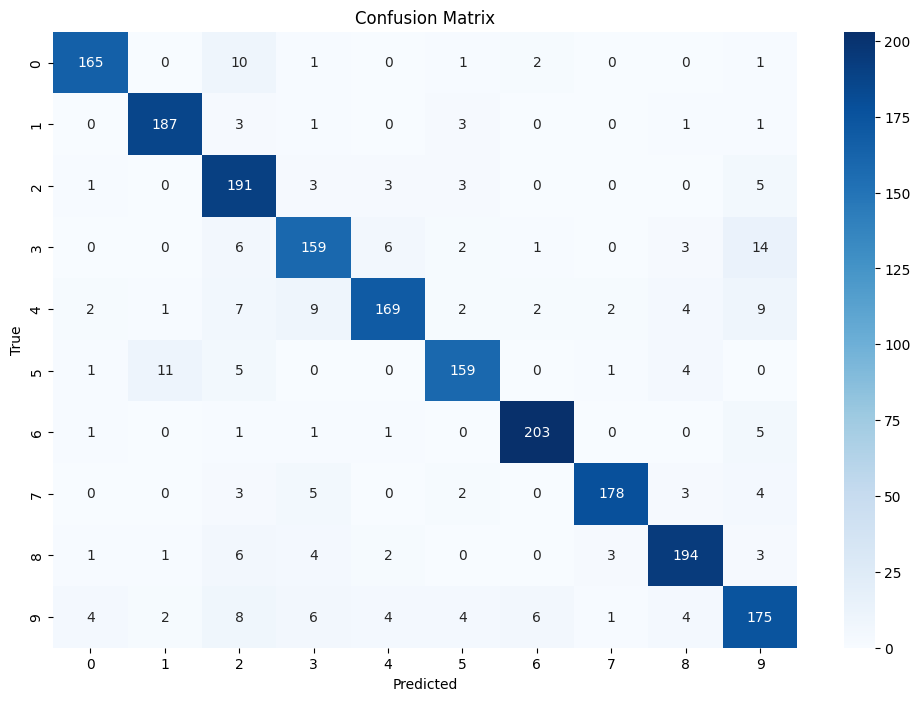

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Menampilkan confusion matrix
print("Confusion Matrix:")
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=np.arange(num_labels),
            yticklabels=np.arange(num_labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

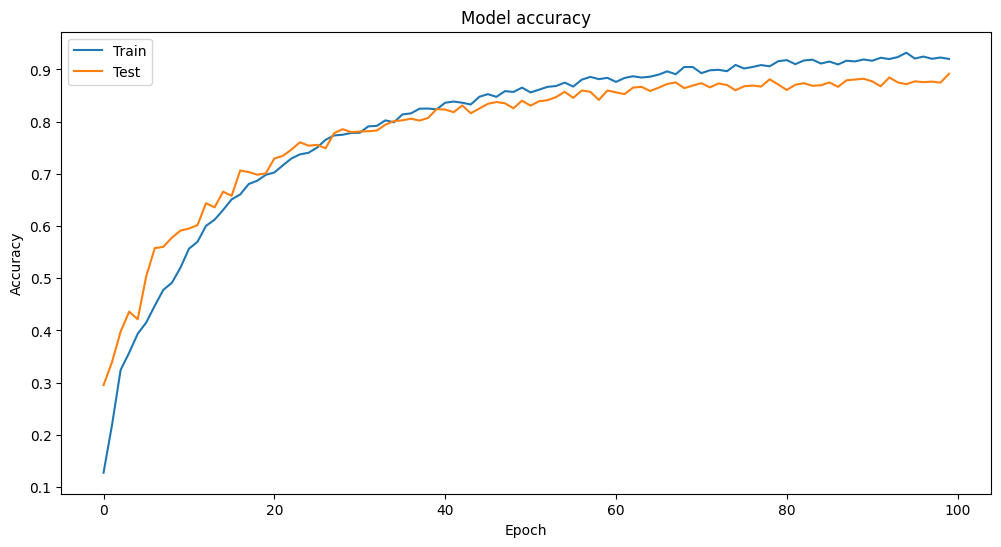

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

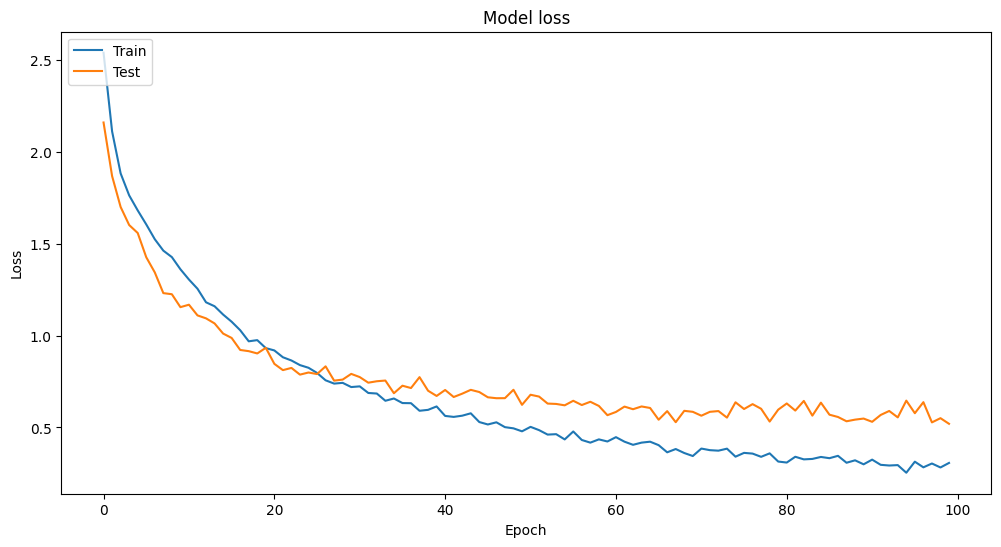

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

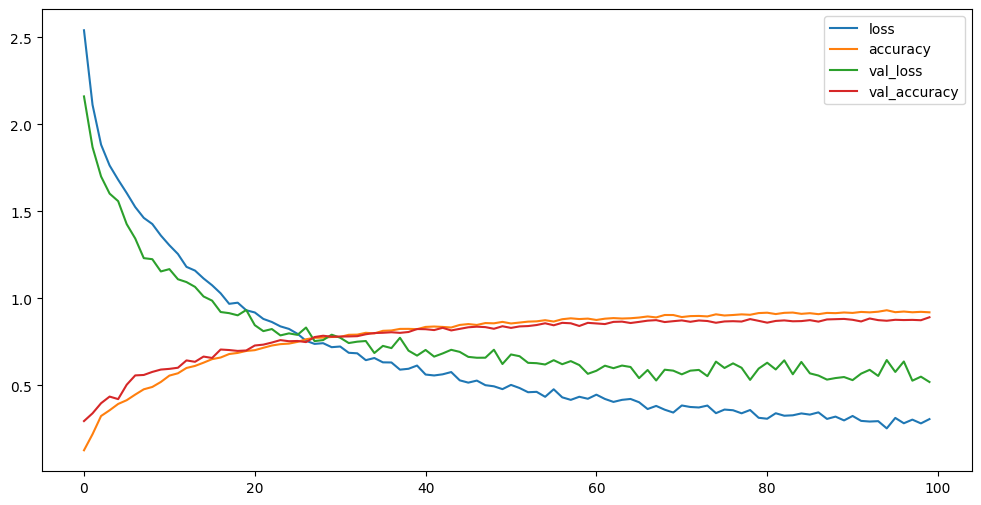

In [ ]:
pd.DataFrame(history.history).plot(figsize=(12, 6))
plt.show()

In [ ]:
model.predict(X_test)

63/63 [==============================] - 1s 6ms/step


array([[0.12023021, 0.00147006, 0.06066038, ..., 0.00195518, 0.01876754,
        0.27381578],
       [0.05503989, 0.0337186 , 0.18611586, ..., 0.06545885, 0.15177186,
        0.14180249],
       [0.08015033, 0.0591092 , 0.24112727, ..., 0.03922233, 0.12274654,
        0.10583738],
       ...,
       [0.08046214, 0.07518058, 0.20435835, ..., 0.0555355 , 0.12395489,
        0.09778824],
       [0.09392887, 0.04951672, 0.27069184, ..., 0.02540738, 0.11167345,
        0.10076828],
       [0.05611401, 0.00853779, 0.13069907, ..., 0.02827304, 0.12558818,
        0.19520228]], dtype=float32)

## Testing Manual Dengan Data

In [ ]:
filename = "/content/drive/MyDrive/Colab Notebooks/PPDM/Data-Audio/genres_original/metal/metal.00000.wav"
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast')
mfcc_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfcc_scaled_features = np.mean(mfcc_features.T, axis=0)

print(mfcc_scaled_features)
mfcc_scaled_features = mfcc_scaled_features.reshape(1, -1)
print(mfcc_scaled_features)
print(mfcc_scaled_features.shape)

predicted_label = model.predict(mfcc_scaled_features)
print(predicted_label)

# Convert probabilities to class index
predicted_label_index = np.argmax(predicted_label, axis=1)
print(predicted_label_index)

# Decode the class index to the original label
prediction_class = labelencoder.inverse_transform(predicted_label_index)
print(prediction_class)


[-52.940304    50.09013    -11.491269    46.324932     6.543001
  10.116378     5.4855285    8.844899     5.929942     6.625154
  -4.033035     9.778293    -3.1172316    3.653597    -6.502194
   1.0854731   -4.482196     4.709674    -2.755327     0.4985645
  -9.29338      2.0262656   -3.4876702    2.5047514   -4.658039
  -1.8967493   -5.6836166   -3.1856866   -4.818261     0.85869867
  -5.7388225   -0.4105425   -5.2758536    0.46732435  -0.60271835
  -0.6577608   -2.4302607    1.9490244   -4.047967    -2.844565  ]
[[-52.940304    50.09013    -11.491269    46.324932     6.543001
   10.116378     5.4855285    8.844899     5.929942     6.625154
   -4.033035     9.778293    -3.1172316    3.653597    -6.502194
    1.0854731   -4.482196     4.709674    -2.755327     0.4985645
   -9.29338      2.0262656   -3.4876702    2.5047514   -4.658039
   -1.8967493   -5.6836166   -3.1856866   -4.818261     0.85869867
   -5.7388225   -0.4105425   -5.2758536    0.46732435  -0.60271835
   -0.6577608   -2.4